# Testing Code To Apply PDR Satellite Fraction Finding to UM Model Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy.table import Table , Column
from astropy.io import fits
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
from astropy.coordinates import Angle
from astropy.coordinates import SkyCoord
import copy
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'stixgeneral'
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# import the data file
data_pth = '/Users/astro/Desktop/github/satellite_fraction/data/'
old_model = data_pth + 'um_ins_exs_logms_10.8_asap_180813.fits'
new_model = data_pth + 'um_ins_exs_logms_10.8_asap_180813_vel.fits'
pdr = data_pth + 's16a_massive_logmMax_11.45_z_0.25_0.47_mhalo_pdr_full.fits'


# open pdr file
pdr_open = fits.open(pdr)
z_pdr = pdr_open[1].data['z_best']
pdr_table = Table(pdr_open[1].data)

hdu1 = fits.open(new_model)
new_table = Table(hdu1[1].data) # For accuracy, I will keep all galaxies

#hdu1[1].header
#full_table['upid']

First, I am going to find the ideal cylinder lengths based on sorting by virial mass.

In [3]:
# Get only the galaxies within our mass range
model_table = new_table
        
model_table.sort('logmh_vir')
model_table.reverse() # rank order by mass
model_redshift = 0.37 # this is from um snapshot

# table of pdr data that will be useful later
pdr_cut = Table(names = pdr_table.colnames)

for i in range(len(np.array(pdr_table['logm_max']))):
    if pdr_table['logm_max'][i] > 11.5 and pdr_table['z_best'][i] > .25 and pdr_table['z_best'][i] < .45:
        pdr_cut.add_row(pdr_table[i])

## Test halotools

In [4]:
# remember that some galaxies lack specz => error
from halotools.mock_observables import apply_zspace_distortion
from astropy.cosmology import Planck15 as cosmo # um uses planck cosmology
# find the z-space distortions
z_dis = apply_zspace_distortion(model_table['z'], model_table['vz'], model_redshift, cosmo, 400.0)
model_table['z_dist'] = z_dis

/Users/astro/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Text(0,0.5,'LOS space distortion')

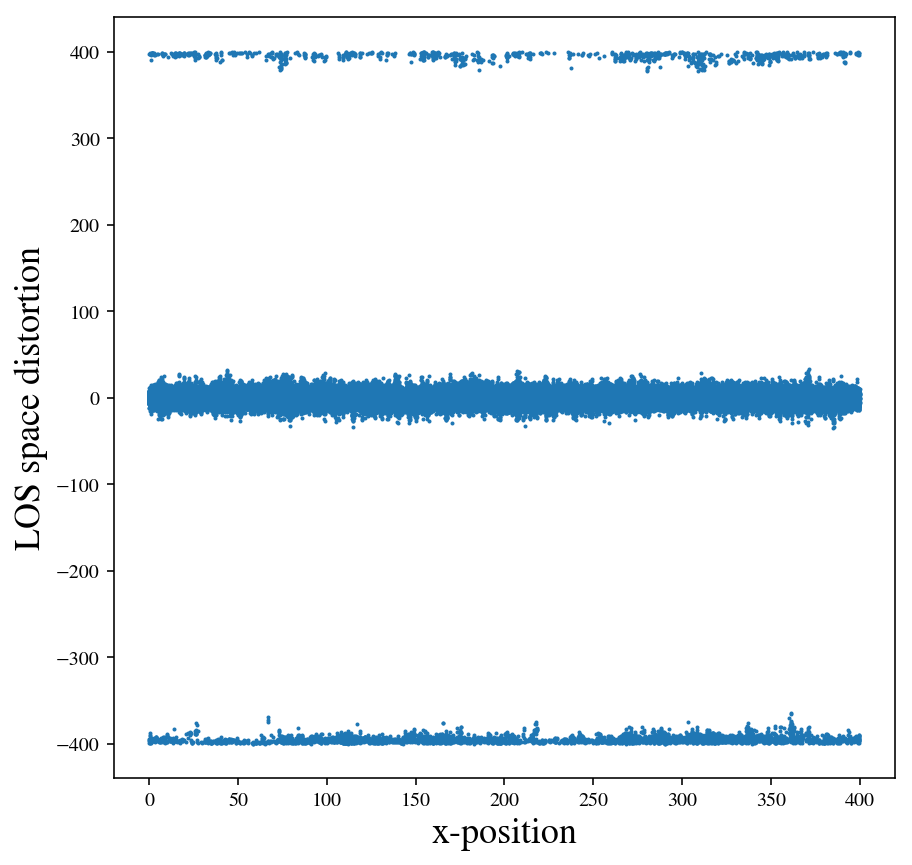

In [5]:
# look at redshift space distortions
fig = plt.figure(figsize = [7,7])

ax1 = fig.add_subplot(111)
ax1.scatter(model_table['x'],model_table['z'] - model_table['z_dist'], s = 1)
ax1.set_xlabel('x-position', fontsize = 18)
ax1.set_ylabel('LOS space distortion', fontsize = 18)

So it looks like the z-space distortions aren't bad. (The odd points at $\pm400$ are from the box size of the um model, which is $400Mpc$)

* Some of the galaxy positions are now weird because of the periodic boundary conditions.

* The next order of business is to turn the coordinates into comoving real h.

In [6]:
# first define the cosmology in colossus
# I'm using the same cosmology stated in SMDPL documentation
import colossus
from colossus.cosmology import cosmology
params = {'flat': True , 'H0': 67.77 , 'Om0': 0.307115 , 'Ob0': 0.048206, 'sigma8': 0.8228, 'ns': 0.96}
h = 0.6777
cosmology.addCosmology('SMDPL',params) # this is what Song had me use when doing the sat frac
cosmo = cosmology.setCosmology('SMDPL')
from colossus.halo import mass_so


In [7]:
# get rid of h in spatial coords
model_table['z_dist'] = model_table['z_dist']/h
model_table['x'] = model_table['x']/h
model_table['y'] = model_table['y']/h

Now I want to find the satellite fraction through the same process as the pdr region, except with a length cut.


### Apply same method to catalog

## True Satellite Fraction

* I just copy/pasted this from my other notebook. It needs some edits to keep it in similar form as other method

In [8]:
centrals_true = model_table[model_table['upid'] == -1]
sats_true = model_table[model_table['upid'] != -1]

print(len(centrals_true), len(sats_true))

# from Song's satellite finding code
mass_bins = [11.5, 11.6, 11.7, 11.8, 11.9, 12.0, 12.1, 12.2, 12.3]

hist_all, edges_all = np.histogram(model_table['logms_max'], bins=mass_bins)
hist_cen, edges_cen = np.histogram(centrals_true['logms_max'], bins=mass_bins)
hist_sat, edges_sat = np.histogram(sats_true['logms_max'], bins=mass_bins)

mass_center_true = np.log10((10**edges_all[1:] + 10**edges_all[:-1]) / 2)

f_sat_true = (hist_sat / hist_all) * 100

372110 344640


In [9]:
# cut model table like marie mentioned

# Cut in Mh_vir to speed things up
stellarcut_indices = np.where(model_table['logms_max'] > 11.5)[0]

# row index where 95% of galaxies with M_* > 11.5 are above it
last_idx = stellarcut_indices[int(len(stellarcut_indices)*0.98)]
UM_cut = model_table[0:last_idx]

In [10]:
# get virial radii
mvir = UM_cut['logmh_vir']

# m_to_r use 'vir' definition
r_h = mass_so.M_to_R((10**mvir)*h , .37, 'vir') * 1e-3 #Mpc/h

UM_cut['r_vir'] = (r_h / h) * (1.37) #comoving Mpc

# Make an index column
UM_cut['index'] = np.zeros(len(UM_cut['logms_max']))
for i in range(len(UM_cut['index'])):
     UM_cut['index'][i] = i

In [11]:
print(len(UM_cut))

164497


$\Rightarrow$ When I am applying this method, there are two key differences from the PDR
* $\Delta z$ cut is now a $\Delta \ell$ cut
* Distance between galaxies is calculated using x-y coordinates instead of RA and Dec

After discussions and new catalogs, I will use the following when doing analysis:
* $\ell = 3 Mpc$ >Marie's number
* $\ell = 5 Mpc$ 
* $\ell = 10 Mpc$ $\Rightarrow$ velocity dispersion
* $\ell = 15 Mpc$ >Chris' number

In [12]:
import satellite_finder as sf

## Run using different  $\ell$ cuts

#### First, $\ell = 3$Mpc

In [13]:
#mass_center_3mpc, f_sat_3mpc, err_3mpc = sf.run_model_satellite(UM_cut, 3, mass_bins)

#### $\ell = 5$ Mpc

In [14]:
#mass_center_5mpc, f_sat_5mpc, err_5mpc = sf.run_model_satellite(UM_cut, 5, mass_bins)

#### $\ell = 10$ Mpc

In [15]:
mass_center_10mpc, f_sat_10mpc, err_10mpc = sf.run_model_satellite(UM_cut, 10, mass_bins, 'vir')

#### $\ell = 15$ Mpc (assume ideal for now)

In [16]:
mass_center_15mpc, f_sat_15mpc, err_15mpc = sf.run_model_satellite(UM_cut, 15, mass_bins,'vir')

--------------- Error Bars --------------
* Song said I should put some "naive" error bars for reference. I will just do counting error.
$$ \sigma = \sqrt{n_{sat}}/n_{all} * 100 $$

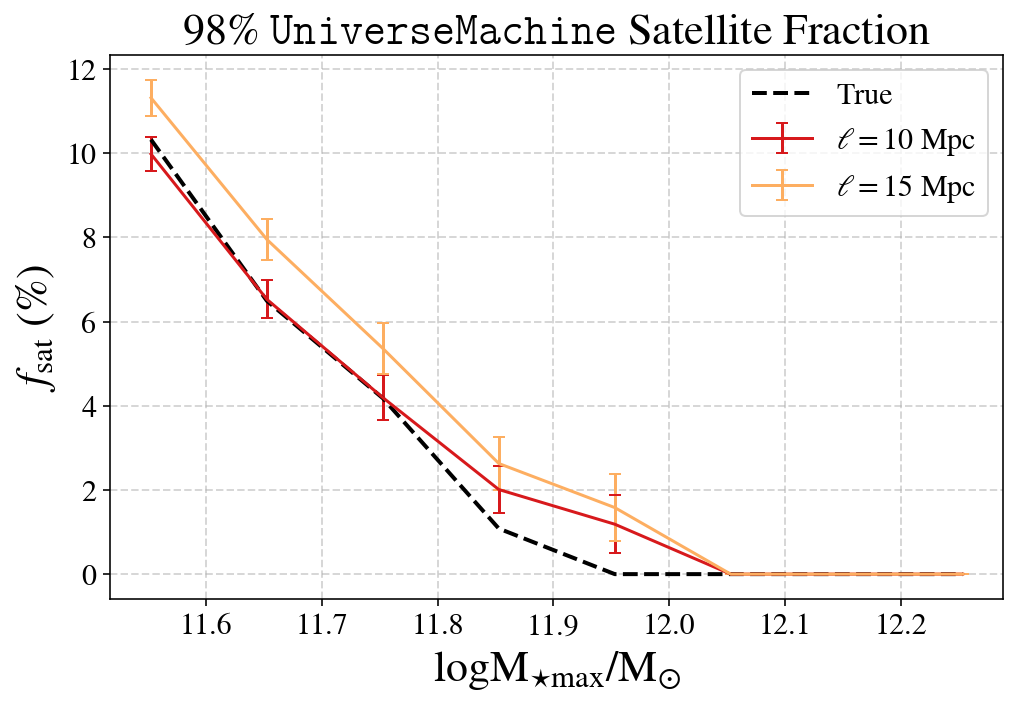

In [30]:
fig = plt.figure(figsize = [8,5])
ax1 = fig.add_subplot(111)
ax1.grid(linewidth=1, linestyle='--', alpha=0.5)

#ax1.errorbar(mass_center_3mpc , f_sat_3mpc, yerr = err_3mpc, capsize = 3, color = '#2c7bb6', label = '$\ell = 3$ Mpc')
#ax1.errorbar(mass_center_5mpc , f_sat_5mpc, yerr = err_5mpc, capsize = 3, color = '#abd9e9', label = '$\ell = 5$ Mpc')
ax1.errorbar(mass_center_10mpc , f_sat_10mpc, yerr = err_10mpc, capsize = 3, color = '#d7191c', label = '$\ell = 10$ Mpc')
ax1.errorbar(mass_center_15mpc , f_sat_15mpc, yerr = err_15mpc, capsize = 3, color = '#fdae61', label = '$\ell = 15$ Mpc')
ax1.plot(mass_center_true , f_sat_true, color = 'k', linewidth = 2,ls = '--', label = 'True')

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(15) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(15)

ax1.set_xlabel(r'$\log \rm M_{\star \rm max} / M_{\odot}$', fontsize = 22)
ax1.set_ylabel(r'$f_{\rm sat}$ (%)', fontsize = 22)
ax1.set_title('98% $\mathtt{UniverseMachine}$ Satellite Fraction', fontsize = 22)
ax1.legend(fontsize = 15)
plt.savefig('um_fsat.png', dpi = 1000)

### 8/27
I've run the satellite finder on the mock galaxies after ordering by virial mass, which ensures we don't miss satellites in whatever data we are working with (mass cut). Unfortunately, we do not have the luxury of doing that in the observational data, so I will run the tests on the mock galaxies sorting by stellar mass.

In [18]:
# Rename the full table again
model_table_2 = new_table
model_table_2.sort('logms_max')
model_table_2.reverse() # rank order by stellar mass

In [19]:
# cut model table like marie mentioned (again)

# Cut in Mh_vir to speed things up
stellarcut_indices = np.where(model_table_2['logms_max'] > 11.5)[0]

# row index where 95% of galaxies with M_* > 11.5 are above it
last_idx = stellarcut_indices[int(len(stellarcut_indices)*0.98)]
UM_stellar_cut = model_table[0:last_idx]

In [20]:
# get virial radii
mvir = UM_stellar_cut['logmh_vir']

# m_to_r use 'vir' definition
r_h = mass_so.M_to_R((10**mvir)*h , .37, 'vir') * 1e-3 #Mpc/h

UM_stellar_cut['r_vir'] = (r_h / h) * (1.37) #comoving Mpc

# Make an index column
UM_stellar_cut['index'] = np.zeros(len(UM_stellar_cut['logms_max']))
for i in range(len(UM_stellar_cut['index'])):
     UM_stellar_cut['index'][i] = i

In [33]:
# run again with the new sorting
(mass_15mpc_stellarcut, 
 f_sat_15mpc_stellarcut, 
 err_15mpc_stellarcut) = sf.run_model_satellite(UM_stellar_cut, 15, mass_bins, 'ms')

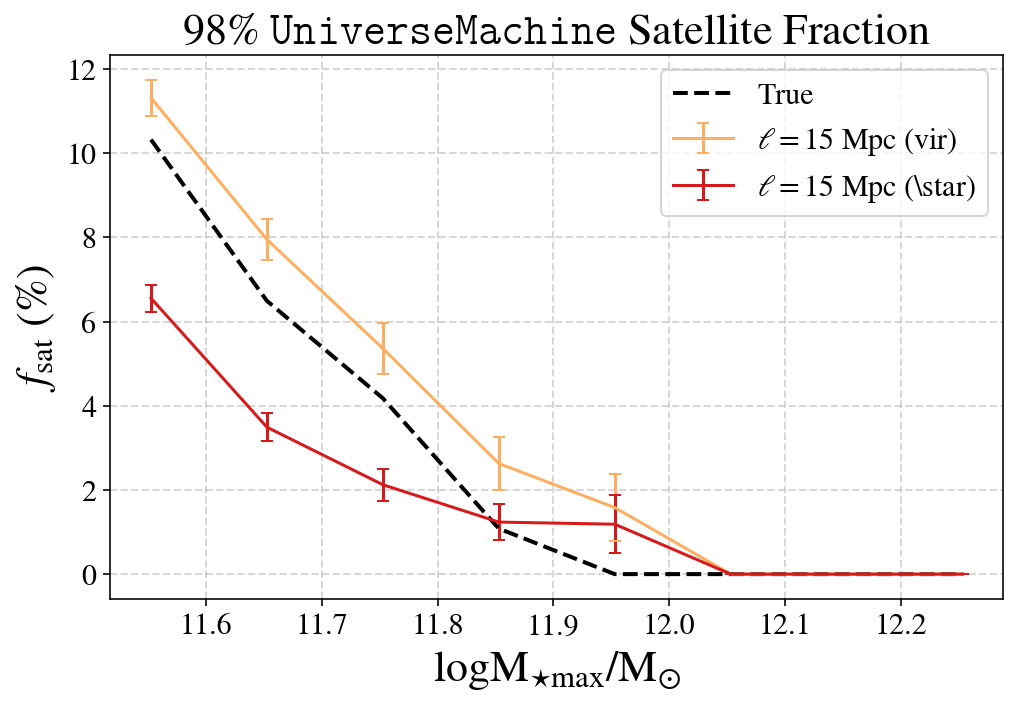

In [34]:
fig = plt.figure(figsize = [8,5])
ax1 = fig.add_subplot(111)
ax1.grid(linewidth=1, linestyle='--', alpha=0.5)

#ax1.errorbar(mass_center_3mpc , f_sat_3mpc, yerr = err_3mpc, capsize = 3, color = '#2c7bb6', label = '$\ell = 3$ Mpc')
#ax1.errorbar(mass_center_5mpc , f_sat_5mpc, yerr = err_5mpc, capsize = 3, color = '#abd9e9', label = '$\ell = 5$ Mpc')
#ax1.errorbar(mass_center_10mpc , f_sat_10mpc, yerr = err_10mpc, capsize = 3, color = '#d7191c', label = '$\ell = 10$ Mpc')
ax1.errorbar(mass_center_15mpc , f_sat_15mpc, yerr = err_15mpc, capsize = 3, color = '#fdae61', label = '$\ell = 15$ Mpc (vir)')
ax1.errorbar(mass_15mpc_stellarcut , f_sat_15mpc_stellarcut, yerr = err_15mpc_stellarcut, capsize = 3, color = '#d7191c', label = '$\ell = 15$ Mpc (\star)')

ax1.plot(mass_center_true , f_sat_true, color = 'k', linewidth = 2,ls = '--', label = 'True')

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(15) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(15)

ax1.set_xlabel(r'$\log \rm M_{\star \rm max} / M_{\odot}$', fontsize = 22)
ax1.set_ylabel(r'$f_{\rm sat}$ (%)', fontsize = 22)
ax1.set_title('98% $\mathtt{UniverseMachine}$ Satellite Fraction', fontsize = 22)
ax1.legend(fontsize = 15)
plt.savefig('um_fsat.png', dpi = 1000)

## Correction factor
Using the "ideal" 15 Mpc length, find a correction factor of:
$$C = \frac{f_{\rm sat, alg}}{f_{\rm sat, UM}}$$

In [46]:
C  = f_sat_true / f_sat_15mpc_stellarcut
C

array([1.5746469 , 1.85964912, 1.96774194, 0.875     , 0.        ,
              nan,        nan,        nan])

#### Now we want to mock up photo-z errors.



1) Using `numpy.random.rand()`, I will draw random numbers based on the amount of galaxies with only photo-z

2) I will multiply the array of random numbers by the size of the galaxy bins, then convert those numbers to integers.

3) The integers will correspond to the indices of the rows of the table. These will be given the extra distortion, which I will work on next.

In [24]:
# find photo z fractions
pdr_no_specz = np.isnan(pdr_cut['z_spec'])

pdr_photoz = Table(names = pdr_cut.colnames) # table for only photo-z

for i in range(len(pdr_cut)):
    if pdr_no_specz[i] == True:
        pdr_photoz.add_row(pdr_cut[i])

hist_pdr, edges_pdr = np.histogram(pdr_cut['logm_max'], bins = mass_bins)
hist_phot_z, edges_phot_z = np.histogram(pdr_photoz['logm_max'], bins = mass_bins)

photoz_frac = hist_phot_z/hist_pdr

In [25]:
# Find how many random numbers to draw (In the least efficient way possible)

hist_cut, edges_cut = np.histogram(UM_stellar_cut['logms_max'],mass_bins)

random_sample0 = np.random.rand(int(photoz_frac[0]*hist_cut[0]))
random_index0 = random_sample0 * hist_cut[0]

random_sample1 = np.random.rand(int(photoz_frac[1]*hist_cut[1]))
random_index1 = hist_cut[0]+(random_sample1 * hist_cut[1])

random_sample2 = np.random.rand(int(photoz_frac[2]*hist_cut[2]))
random_index2 =hist_cut[0]+hist_cut[1]+ (random_sample2 * hist_all[2])

random_sample3 = np.random.rand(int(photoz_frac[3]*hist_cut[3]))
random_index3 = hist_cut[0]+hist_cut[1]+hist_cut[2]+(random_sample3 * hist_cut[3])

random_sample4 = np.random.rand(int(photoz_frac[1]*hist_cut[4]))
random_index4 = hist_cut[0]+hist_cut[1]+hist_cut[2]+hist_cut[3]+(random_sample4 * hist_cut[4])

random_index = np.concatenate((random_index0, random_index1, random_index2, random_index3, random_index4), axis = 0)

# Turn array of indices into integers
for i in range(len(random_index)):
    random_index[i] = np.int(random_index[i])
    

random_index_integer = random_index.astype(int) # this is the final array of numbers to use
#random_index_integer

This next part (actually creating and applying the kick) is where I'm a bit more unclear. I'm going to do what I *think* I'm supposed to do and see where that gets me. I will lay that out in the following markdown cell.

So from what Marie sent, I'm looking at a scatter of the form
$$ \sigma = \frac{\Delta z}{1 + z} \sim 0.03$$
If I'm supposed to find the $\Delta z$ and the corresponding comoving distance, then I would rearrange the function as $ \Delta z \sim 0.03(1 + z) $. In this case, $ z = z_{UM} = .37 $. Plugging in yields $\Delta z \sim 0.04$. From this, I can use `cosmo.comovingDistance()` to find the $\ell$. Once I have that, I will use `np.random.normal(0.0, cosmo.comovingDistance(.37, .37+.04))` for the kick.

In [26]:
delta_z = 0.04 # from above
l_comoving = cosmo.comovingDistance(0.37, 0.37 +delta_z)
print(l_comoving)

# here are the random distortions
l_kick = np.random.normal(0.0, l_comoving, size = len(random_index))

97.33310586022465


In [27]:
# ---------- Now add the distortions to the model data ----------

# Copy the original table so I can mess with the z-column
UM_vir_with_kick = copy.deepcopy(UM_cut)
UM_ms_with_kick = copy.deepcopy(UM_stellar_cut)


# Add errors to the random rows
for i in range(len(random_index_integer)):
    UM_vir_with_kick['z_dist'][random_index_integer[i]] = \
    UM_vir_with_kick['z_dist'][random_index_integer[i]] + l_kick[i]
    UM_ms_with_kick['z_dist'][random_index_integer[i]] = \
    UM_ms_with_kick['z_dist'][random_index_integer[i]] + l_kick[i]

In [53]:
# ---------- Now run sat finding code ---------


# ---------- l = 16 ---------------------------------------
(mass_center_20mpc_kick, 
 f_sat_20mpc_kick, 
 err_20mpc_kick )= sf.run_model_satellite(UM_ms_with_kick, 20, mass_bins, 'ms')

In [28]:
# ---------- l = 15 ---------------------------------------
(mass_center_15mpc_kick_ms, 
 f_sat_15mpc_kick_ms, 
 err_15mpc_kick_ms )= sf.run_model_satellite(UM_ms_with_kick, 15, mass_bins, 'ms')

In [47]:
C[4::]=1
C

array([1.5746469 , 1.85964912, 1.96774194, 0.875     , 1.        ,
       1.        , 1.        , 1.        ])

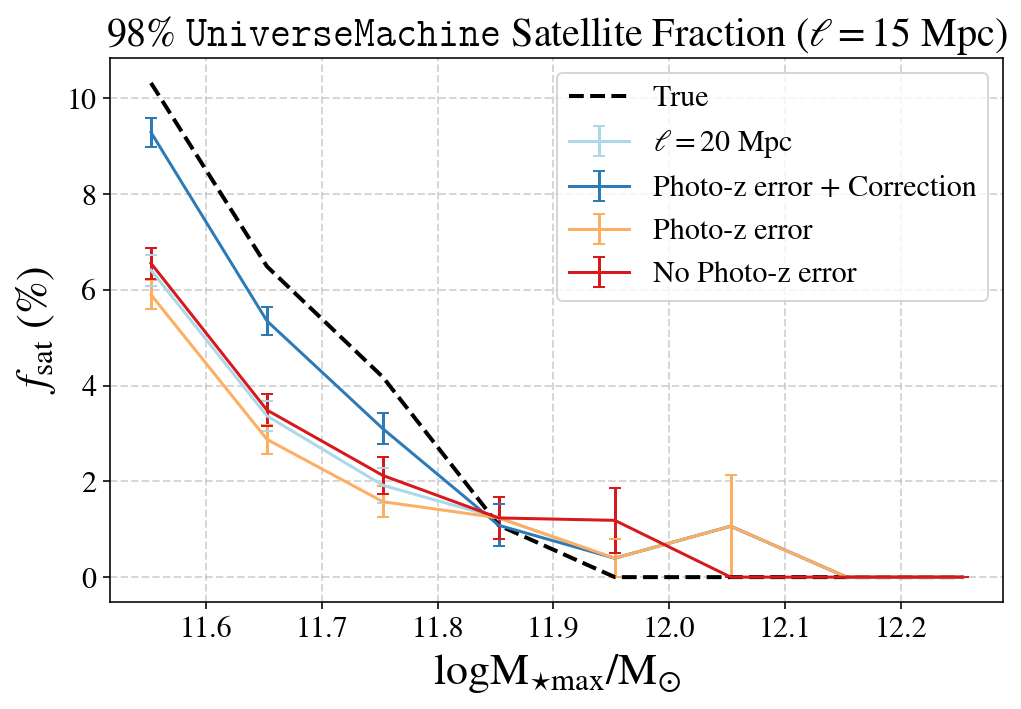

In [55]:
fig = plt.figure(figsize = [8,5])
ax1 = fig.add_subplot(111)
ax1.grid(linewidth=1, linestyle='--', alpha=0.5)

ax1.errorbar(mass_center_20mpc_kick, f_sat_20mpc_kick, yerr = err_20mpc_kick, capsize = 3, color = '#abd9e9', label = '$\ell = 20$ Mpc')

ax1.errorbar(mass_center_15mpc_kick_ms, C*f_sat_15mpc_kick_ms, yerr = err_15mpc_kick_ms, capsize = 3, color = '#2c7bb6', label = 'Photo-z error + Correction')

ax1.errorbar(mass_center_15mpc_kick_ms, f_sat_15mpc_kick_ms, yerr = err_15mpc_kick_ms, capsize = 3, color = '#fdae61', label = 'Photo-z error')
ax1.errorbar(mass_15mpc_stellarcut , f_sat_15mpc_stellarcut, yerr = err_15mpc_stellarcut, capsize = 3, color = '#d7191c', label = 'No Photo-z error')

ax1.plot(mass_center_true , f_sat_true, color = 'k', linewidth = 2,ls = '--', label = 'True')

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(15) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(15)

ax1.set_xlabel(r'$\log \rm M_{\star \rm max} / M_{\odot}$', fontsize = 22)
ax1.set_ylabel(r'$f_{\rm sat}$ (%)', fontsize = 22)
ax1.set_title('98% $\mathtt{UniverseMachine}$ Satellite Fraction ($\ell = 15$ Mpc)', fontsize = 20)
ax1.legend(fontsize = 15)
plt.savefig('um_fsat.png', dpi = 1000)